In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


2022-03-30 11:29:27.945791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 11:29:27.945829: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
generator = keras.models.load_model('../datas/weights/generator-msg.h5')

In [4]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 1, 128)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 4, 4, 512)    1049088     reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4, 4, 512)    2048        conv2d_transpose[0][0]           
______________________________________________________________________________________________

In [5]:
generator.compile()

In [6]:
def plot_examples(images_at_scales):
    n_examples = images_at_scales[0].shape[0]
    fig, axes = plt.subplots(figsize=(5, n_examples), nrows=n_examples, ncols=5, dpi=200)
    for i in range(n_examples):
        for j in range(5):
            generated_images = images_at_scales[4-j]
            gen_1 = generated_images[i].numpy()*127.5+127.5
            axes[i, j].axis('off')
            axes[i, j].imshow((gen_1).astype("uint32"), interpolation='none')
    plt.show()

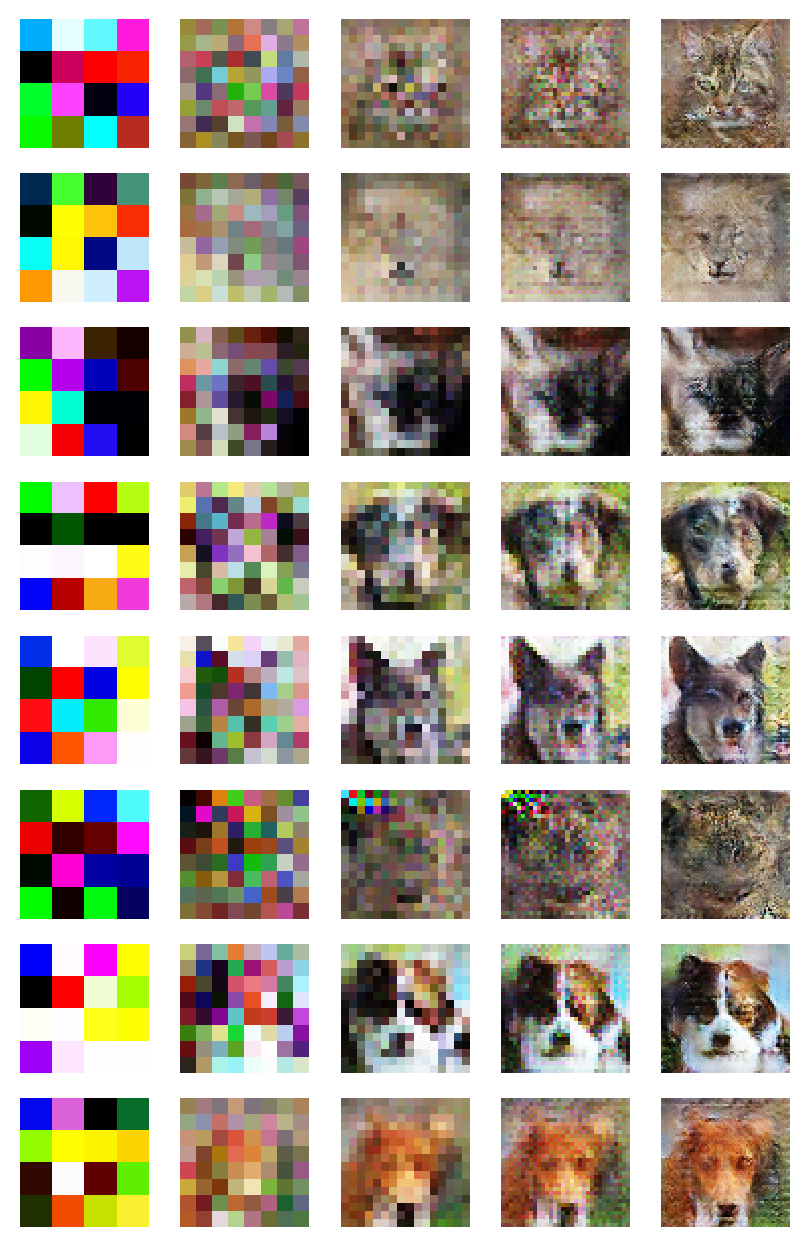

In [9]:
latent_dim = 128

noises = tf.random.normal([8, latent_dim])
example_images = generator(noises, training=False)

plot_examples(example_images)

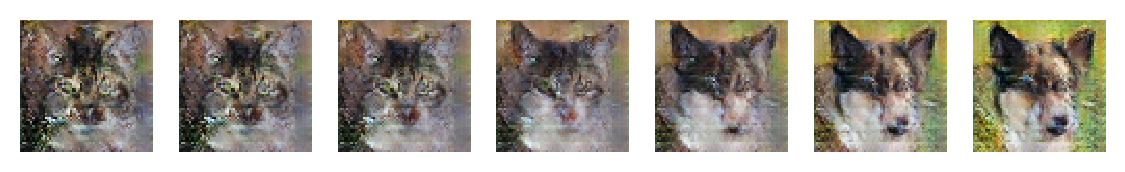

In [10]:
from scipy.interpolate import interp1d
import numpy as np


noises = tf.random.normal([2, latent_dim])

res = []

step_size = 8
for i in range(1, len(noises)):
    linfit = interp1d([1, step_size], np.vstack([noises[i-1], noises[i]]), axis=0)
    
    for j in range(1,step_size):
        generated_image = generator(linfit(j).reshape(1,latent_dim), training=False)
        res.append(generated_image)
        
fig, axes = plt.subplots(figsize=(len(res), 1), nrows=1, ncols=len(res), dpi=200)

for i in range(len(res)):
    gen_1 = res[i][0][0].numpy()*127.5+127.5
    axes[i].axis('off')
    axes[i].imshow((gen_1).astype("uint32"), interpolation='none')
plt.show()

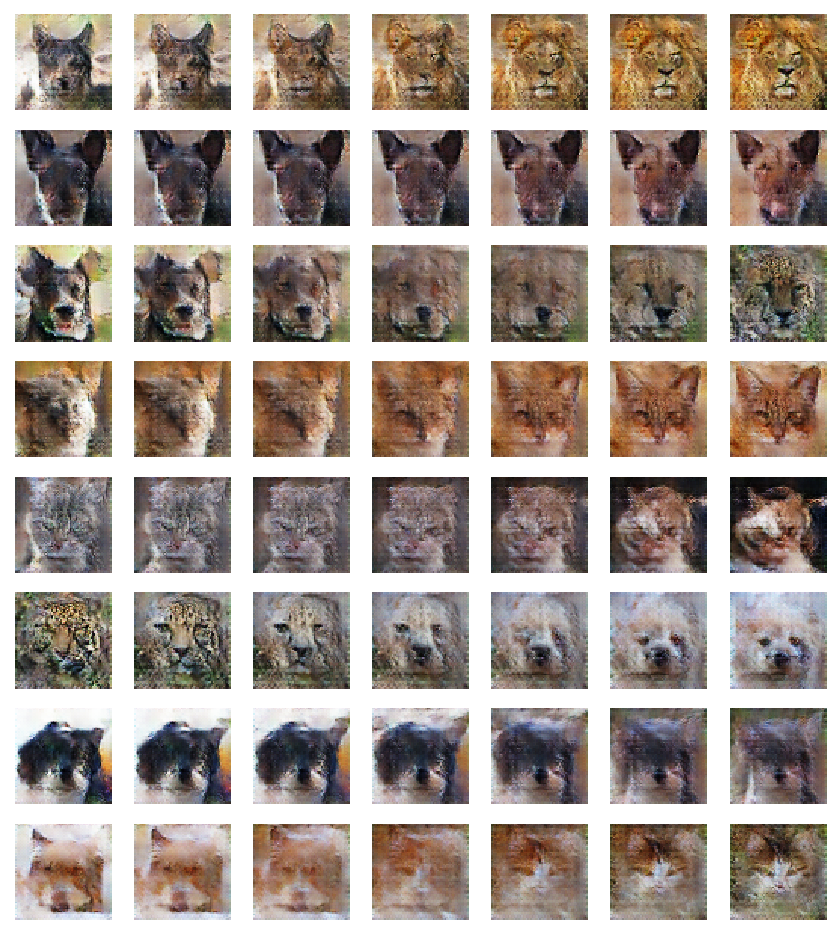

In [11]:
from scipy.interpolate import interp1d
import numpy as np

rows = 8
step_size = 8
fig, axes = plt.subplots(figsize=(step_size-1, rows), nrows=rows, ncols=step_size-1, dpi=150)

for k in range(rows):
    noises = tf.random.normal([2, latent_dim])
    res = []
    step_size = 8
    for i in range(1, len(noises)):
        linfit = interp1d([1, step_size], np.vstack([noises[i-1], noises[i]]), axis=0)
        for j in range(1,step_size):
            generated_image = generator(linfit(j).reshape(1,latent_dim), training=False)
            res.append(generated_image)
    for i in range(step_size-1):
        gen_1 = res[i][0][0].numpy()*127.5+127.5
        axes[k][i].axis('off')
        axes[k][i].imshow((gen_1).astype("uint32"), interpolation='none')
plt.show()

In [12]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)


# We should use an average loss!!
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

# The generator is performing well, if the discriminator classifies fakes as real(1)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
discriminator = keras.models.load_model('../datas/weights/discriminator-msg.h5')

In [35]:
noise = tf.random.normal([2, latent_dim])
noise2 = tf.random.normal([2, latent_dim])

images = generator(noise2, training=False)
generated_images = generator(noise, training=False)


real_output = discriminator(images, training=False)
fake_output = discriminator(generated_images, training=False)

print(fake_output.shape)

gen_loss = generator_loss(fake_output)
disc_loss = discriminator_loss(real_output, fake_output)

print(gen_loss)
print(disc_loss)

for gen in generated_images:
    print(gen.shape)

(2, 1)
tf.Tensor(8.652216, shape=(), dtype=float32)
tf.Tensor(8.1876135, shape=(), dtype=float32)
(2, 64, 64, 3)
(2, 32, 32, 3)
(2, 16, 16, 3)
(2, 8, 8, 3)
(2, 4, 4, 3)
